<p>
<b>Phương trình:</b><br>
$3u_{t}-\frac{x^{2}}{3}u_{xx}=e^{t}x^{3}$,<br>
</p>

#Thư viện

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import numpy as np
import tensorflow_probability as tfp
import math
import time
import matplotlib.pyplot as plt

In [2]:
pi = math.pi

In [3]:
np.random.seed(70)
tf.random.set_seed(80)

#Khai báo các hàm

In [4]:
def exact_c(x):
  return np.power(x,2)/3

In [5]:
def exact_u(t,x):
  return np.exp(t)*np.power(x,3)

In [6]:
def exact_f(t,x):
  return np.exp(t)*np.power(x,3)

In [7]:
def L2_error(model,f_exact):
  n = 1000
  x = np.random.rand(n,1)
  t = np.random.rand(n,1)
  f_e = f_exact(t,x)

  x = tf.convert_to_tensor(x)
  t = tf.convert_to_tensor(t)

  f_hat = model(t,x)
  f_hat = f_hat.numpy()

  error = math.sqrt(np.sum(np.square(f_e-f_hat)))

  L2 = error/n
  return L2

In [8]:
def train(dataset,optimizer,model_f,batch_size,epochs,loss_hist):
  for epoch in range(epochs):
    print("Epoch "+str(epoch+1))
    data = tf.data.Dataset.from_tensor_slices(dataset).shuffle(dataset.shape[0]).batch(batch_size)

    i = 0
    total_loss = 0
    for batch in data:
      i = i + 1
      t = batch[:,0:1]
      x = batch[:,1:2]
      y = batch[:,2:3]

      with tf.GradientTape() as tape:
        f = model_f(t,x)
        loss_value = tf.reduce_mean(tf.math.square(f-y))

      grads = tape.gradient(loss_value, model_f.weights)
      optimizer.apply_gradients(zip(grads,model_f.weights))

      if (i%100)==0:
        print(loss_value)

      total_loss = total_loss + loss_value
    
    loss_hist.append(total_loss.numpy())
  print("Complete training!")

#Tạo dữ liệu và model

In [9]:
h = 0.02
delta_t = 0.01

In [10]:
#trong miền
x = np.expand_dims(np.arange(0,1-2*h,step = h), axis = 1).astype('float32')
t = np.expand_dims(np.arange(0,1-2*delta_t,step = delta_t),axis = 1).astype('float32')

m = x.shape[0]
n = t.shape[0]

u = []
#u0
#one = np.ones((m+1,1))*t[0]
#u0 = exact_u(one,x)
#u1  
#one = np.ones((m+1,1))*t[1]
#u1 = exact_u(one,x)

for i in range(t.shape[0]):
  one = np.ones((m,1))*t[i]
  u_t = exact_u(one,x)
  u.append(u_t)

c = []

y = []
u_t = []
u_xx = []
for i in range(0,n-1):
  for j in range(1,m-1):
    u_t_i = (u[i+1][j]-u[i][j])/delta_t
    u_t.append(u_t_i)
    u_xx_i = ((u[i][j+1]+u[i][j-1]-2*u[i][j])+(u[i+1][j+1]+u[i+1][j-1]-2*u[i+1][j]))/(2*h*h)
    u_xx.append(u_xx_i)
    c_j = exact_c(x[j])
    c.append(c_j)

u_t = np.array(u_t)
u_xx = np.array(u_xx)
c = np.array(c)
y = 3*u_t - c*u_xx

x = x[1:m-1]
X = x.copy()
for i in range(n-2):
  X = np.concatenate((X,x),axis = 0)

T = np.ones((m-2,1))*t[0]
for i in range(1,n-1):
  one = np.ones((m-2,1))*t[i]
  T = np.concatenate((T,one),axis = 0)

In [11]:
m

48

In [12]:
n

98

In [13]:
y.shape

(4462, 1)

In [14]:
dataset = np.concatenate((T,X,y),axis = 1).astype('float32')
print(dataset.shape)

(4462, 3)


In [15]:
class Model(tf.keras.Model):
  def __init__(self):
    super(Model,self).__init__()
    self.model = keras.Sequential([
        keras.layers.Dense(1,activation="relu"),
        keras.layers.Dense(32,activation="relu"),
        keras.layers.Dense(32,activation="relu"),
        keras.layers.Dense(32,activation="relu"),
        keras.layers.Dense(32,activation="relu"),
        keras.layers.Dense(1)
    ])
    self.model2 = keras.Sequential([
        keras.layers.Dense(2,activation="relu"),
        keras.layers.Dense(32,activation="relu"),
        keras.layers.Dense(32,activation="relu"),
        keras.layers.Dense(32,activation="relu"),
        keras.layers.Dense(32,activation="relu"),
        keras.layers.Dense(1)
    ])
  def call(self,t,x):
    output1 = self.model(t)
    output2 = self.model2(t,x)
    output3 = self.model(x)
    return output1*output2*output3

In [16]:
NNf = Model()

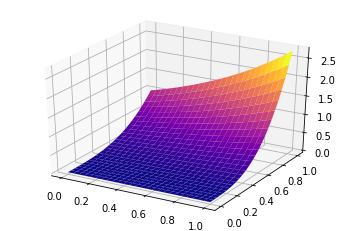

In [28]:
ax = plt.axes(projection = "3d")

x = np.arange(0,1+h,step = h)
t = np.arange(0,1+h,step = h)

X,T = np.meshgrid(x,t)
Y = exact_f(T,X)

ax.plot_surface(T,X,Y,cmap = "plasma")
plt.show()

In [27]:
Y.shape

(51, 51)

In [26]:
T.shape

(51, 51)

#Training

In [18]:
epochs = 200
loss_fn = tf.keras.losses.MeanSquaredError()
batch_size = 8
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
loss_hist = []

In [19]:
start = time.time()
train(dataset,optimizer,NNf,batch_size,epochs,loss_hist=loss_hist)
end = time.time()

Epoch 1
tf.Tensor(0.11689766, shape=(), dtype=float32)
tf.Tensor(0.11897384, shape=(), dtype=float32)
tf.Tensor(0.048670925, shape=(), dtype=float32)
tf.Tensor(0.058596738, shape=(), dtype=float32)
tf.Tensor(0.018662004, shape=(), dtype=float32)
Epoch 2
tf.Tensor(0.015798103, shape=(), dtype=float32)
tf.Tensor(0.009595626, shape=(), dtype=float32)
tf.Tensor(0.013651218, shape=(), dtype=float32)
tf.Tensor(0.009166512, shape=(), dtype=float32)
tf.Tensor(0.0051088114, shape=(), dtype=float32)
Epoch 3
tf.Tensor(0.002363591, shape=(), dtype=float32)
tf.Tensor(0.008205924, shape=(), dtype=float32)
tf.Tensor(0.0030742537, shape=(), dtype=float32)
tf.Tensor(0.0056685302, shape=(), dtype=float32)
tf.Tensor(0.0012685843, shape=(), dtype=float32)
Epoch 4
tf.Tensor(0.006889062, shape=(), dtype=float32)
tf.Tensor(0.033278372, shape=(), dtype=float32)
tf.Tensor(0.0010794601, shape=(), dtype=float32)
tf.Tensor(0.0014452143, shape=(), dtype=float32)
tf.Tensor(0.0010252129, shape=(), dtype=float32)
Epo

#Đánh giá

In [20]:
end = time.time()
training_time = end-start
print(training_time)

3202.974043369293


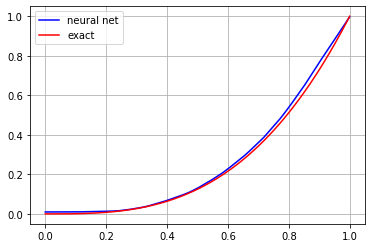

In [21]:
x_test = np.expand_dims(np.linspace(start = 0,stop = 1,num = 1000),1)
t_test = np.zeros((x_test.shape[0],1))
f = NNf(t_test,x_test)
f_ex = exact_f(t_test,x_test)

plt.plot(x_test.squeeze(1), f.numpy().squeeze(1),marker = 'o',markersize = 0.01,color = 'b',label = 'neural net')
plt.plot(x_test.squeeze(1), f_ex.squeeze(1),markersize = 0.01,color = 'r',label = 'exact')

plt.legend()
plt.grid()
plt.show()

In [22]:
L2_error(NNf,exact_f)

0.0005980796570033083

In [23]:
loss_hist = np.array(loss_hist)
epoch = np.arange(1,epochs + 1,step = 1)

No handles with labels found to put in legend.


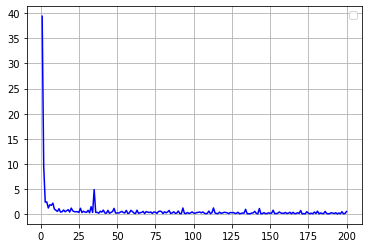

In [24]:
plt.plot(epoch, loss_hist,marker = 'o',markersize = 0.01,color = 'b')

plt.legend()
plt.grid()
plt.show()

In [32]:
x = np.arange(0,1+h,step = h)
t = np.arange(0,1+h,step = h)
y = []
for t_i in t:
  y_i = []
  for x_j in x:
    y_i.append(NNf(np.array([[t_i]]),np.array([[x_j]])).numpy())
  y.append(y_i)
y = np.array(y)

In [35]:
y.shape

(51, 51)

In [34]:
y = (y.squeeze(3)).squeeze(2)

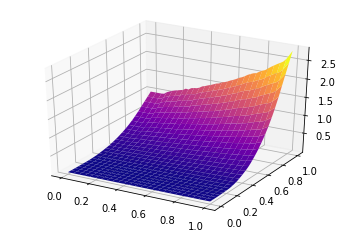

In [36]:
ax = plt.axes(projection = "3d")

X,T = np.meshgrid(x,t)
Y = y

ax.plot_surface(T,X,Y,cmap = "plasma")
plt.show()